In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from sklearn import metrics



import os, glob, inspect, sys, time, warnings


currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib' from '/home/marie-anne/code/Oct20_EPRI/Task1/NB/epri_mc_lib.py'>

# Import data

In [2]:
data_path = "../../Data/Merged_data"
df = pd.read_csv(os.path.join(data_path, 'ALL_TUBE_PIPE_simulated_lite.csv'), 
                 index_col=0)
df.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,A,B,p,Absorption_avg_100,Absorption_avg_200,mean_CF,mean_perm,mean_MBN
Condition,,,,,,,,,,,,
T_B1,12.976905,0.000204,0.021230,0.001822,4.395375e-07,0.001059,0.230070,0.000564,0.000535,1.114476,68.860134,0.431662
T_B1,13.027291,0.000216,0.011716,0.001523,5.583760e-07,0.000984,0.260285,0.000814,0.000370,1.095590,67.558009,0.626825
T_B1,13.005068,0.000200,0.022311,0.000906,9.854555e-07,0.000600,0.225703,0.000959,0.000374,1.095809,69.003866,0.648577
T_B1,12.946765,0.000289,0.012928,0.001658,7.975029e-08,0.001006,0.230207,0.001004,0.000464,1.114609,67.065431,0.408061
T_B1,13.007981,0.000196,0.019996,0.001488,2.552403e-07,0.001033,0.226529,0.000601,0.000218,1.112806,67.652472,0.616882


## Calculating new values

In [3]:
df['AUC_avg'] = mc.findAUC(df, A=df['A'], B=df['B'], p=df['p'], name='AUC_avg')
df.drop(columns=["A","B","p"],inplace=True)

In [4]:
df['CF_perm'] = df['mean_CF']/df['mean_perm'].astype('float64')
df.drop(columns=["mean_MBN","mean_perm","mean_CF"],inplace=True)

## Scaling values

In [5]:
scaled_df = mc.scale_general(df, MinMaxScaler())[0]
scaled_df.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,AUC_avg,CF_perm
Condition,,,,,,,,
T_B1,0.912413,0.210005,0.371914,0.394174,0.329926,0.433469,0.264479,0.073944
T_B1,0.931770,0.223811,0.166988,0.357641,0.434406,0.311245,0.276468,0.074168
T_B1,0.923232,0.205942,0.395177,0.282212,0.495320,0.314618,0.221496,0.071847
T_B1,0.900835,0.305653,0.193088,0.374110,0.514306,0.381013,0.242241,0.076943
T_B1,0.924352,0.200346,0.345332,0.353291,0.345187,0.199210,0.251253,0.075766


## Selecting sub samples

In [6]:
tube, pipe, tube_wo_blind, tube_blind = mc.get_subsample_df(scaled_df)

In [7]:
tube.head()

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,AUC_avg,CF_perm
Condition,,,,,,,,
T_B1,0.912413,0.210005,0.371914,0.394174,0.329926,0.433469,0.264479,0.073944
T_B1,0.931770,0.223811,0.166988,0.357641,0.434406,0.311245,0.276468,0.074168
T_B1,0.923232,0.205942,0.395177,0.282212,0.495320,0.314618,0.221496,0.071847
T_B1,0.900835,0.305653,0.193088,0.374110,0.514306,0.381013,0.242241,0.076943
T_B1,0.924352,0.200346,0.345332,0.353291,0.345187,0.199210,0.251253,0.075766


# Clustering

- **MeanShift**: [`MeanShift`](https://sklearn.org/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift)

- **K-Means**:
[`KMeans`](https://sklearn.org/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)

- **Agglomerative Hierarchical Clustering**:
[`AgglomerativeClustering`](https://sklearn.org/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)


- **Agglomerative Hierarchical Clustering**:
[`KMeans`](https://sklearn.org/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)


    two_means = cluster.KMeans(n_clusters=params['n_clusters']) #use minibatch if too heavy
    
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors") #can also be rbf
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'], xi=params['xi'], min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')


In [83]:
np.random.seed(42)
random_state = 42

default_base = {'quantile': .115, #for bandwidth of RBF kernel in meanshift
                'eps': .3, #max distance between 2 samples for DBSCAN
                'damping': .1, #for Affinity Propagation:the extent to which the current value is maintained relative to incoming values
                'preference': -200, #for Affinity Propagation: each point - points with larger values of preferences are more likely to be chosen as exemplars.
                'n_neighbors': 2, #for k-neighbors graph for the connectivity matrix
                'n_clusters': 4, #for kmeans, ward, spectral, meanshift
                #for kmeans determine on elbow cf model_kmeans_simulated.ipynb
                'min_samples': 3, #fot OPTICS The number of samples in a neighborhood for a point to be considered as a core point
                'xi': 0.05, #for OPTICS Determines the minimum steepness on the reachability plot that constitutes a cluster boundary.
                'min_cluster_size': 0.1, # for optics Minimum number of samples in an OPTICS cluster, expressed as an absolute number or a fraction of the number of samples
                'random_state': random_state
               }

datasets = [
    #(tube, {}),
    (tube_wo_blind, {})
    #(tube_blind, {})
]

In [84]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X  = dataset

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth)
    two_means = cluster.KMeans(n_clusters=params['n_clusters']) #use minibatch if too heavy
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors") #can also be rbf
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'], xi=params['xi'], min_cluster_size=params['min_cluster_size'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(linkage="ward", affinity="euclidean", n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('Kmeans', two_means),
        #('AffinityPropagation', affinity_propagation), EXCLUDED becuase of high complexity, most appropriate for small to medium sized datasets
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('OPTICS', optics),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    labels = pd.DataFrame(index=X.index)
    score = pd.DataFrame()
    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="the number of connected components of the " + "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",category=UserWarning)
            warnings.filterwarnings("ignore", message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.", category=UserWarning)
            
            algorithm.fit(X)

        t1 = time.time()
        
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
        
        labels['label_' + name] = y_pred
        
        silhouette = metrics.silhouette_score(X, labels['label_' + name], metric='euclidean')
        score['silhouette_' + name] = silhouette

    results = pd.concat([X, labels], axis=1)

/home/marie-anne/anaconda3/envs/EPRI/lib/python3.8/site-packages/sklearn/cluster/_birch.py:646: ConvergenceWarning: Number of subclusters found (3) by Birch is less than (4). Decrease the threshold.
  warnings.warn(


# Perform PCA to plot all dimension (n_components = 2)

In [85]:
pca = PCA(n_components=2, svd_solver='full')
transformed = pca.fit_transform(X)
results['PC 1'] = transformed[:,0]
results['PC 2'] = transformed[:,1]
results

,TEP_mean_uV_C,Absorption_avg_500,backscatter_avg,Absorption_avg_50,Absorption_avg_100,Absorption_avg_200,AUC_avg,CF_perm,label_Kmeans,label_MeanShift,label_SpectralClustering,label_Ward,label_AgglomerativeClustering,label_DBSCAN,label_OPTICS,label_Birch,label_GaussianMixture,PC 1,PC 2
Condition,,,,,,,,,,,,,,,,,,,
T_AR,0.926217,0.275402,0.255822,0.318200,0.384746,0.440987,0.195593,0.102052,2,0,0,0,0,0,0,0,2,-0.319156,-0.200310
T_AR,0.917776,0.343975,0.363339,0.343311,0.791600,0.363143,0.116576,0.097075,2,3,0,0,0,0,0,0,2,-0.303862,-0.088265
T_AR,0.925726,0.274045,0.165005,0.333511,0.747980,0.347227,0.187692,0.101733,2,0,0,0,0,0,0,0,2,-0.303164,-0.163118
T_AR,0.900353,0.344850,0.338557,0.317955,0.768540,0.543096,0.171085,0.095744,2,0,0,0,0,0,0,0,2,-0.297971,0.006353
T_AR,0.912150,0.296454,0.221833,0.314970,0.436424,0.309027,0.213912,0.100397,2,0,0,0,0,0,0,0,2,-0.306278,-0.239138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T_HAZ_T,0.922337,0.326558,0.326608,0.388710,0.510010,0.411559,0.259618,0.069058,2,0,0,0,0,0,0,0,2,-0.334304,-0.076014
T_HAZ_T,0.922008,0.361686,0.569053,0.312586,0.217167,0.486271,0.232034,0.072830,2,0,0,0,0,0,0,0,2,-0.351922,-0.082997
T_HAZ_T,0.917452,0.644544,0.461315,0.489060,0.325602,0.232129,0.269120,0.070536,2,0,0,0,0,0,0,0,0,-0.326457,0.009289


AxesSubplot(0.0233854,0.583333;0.147825x0.387302) label_Kmeans
AxesSubplot(0.22733,0.583333;0.147825x0.387302) label_MeanShift
AxesSubplot(0.431274,0.583333;0.147825x0.387302) label_SpectralClustering
AxesSubplot(0.635219,0.583333;0.147825x0.387302) label_Ward
AxesSubplot(0.839163,0.583333;0.147825x0.387302) label_AgglomerativeClustering
AxesSubplot(0.0233854,0.0551587;0.147825x0.387302) label_DBSCAN
AxesSubplot(0.22733,0.0551587;0.147825x0.387302) label_OPTICS
AxesSubplot(0.431274,0.0551587;0.147825x0.387302) label_Birch
AxesSubplot(0.635219,0.0551587;0.147825x0.387302) label_GaussianMixture


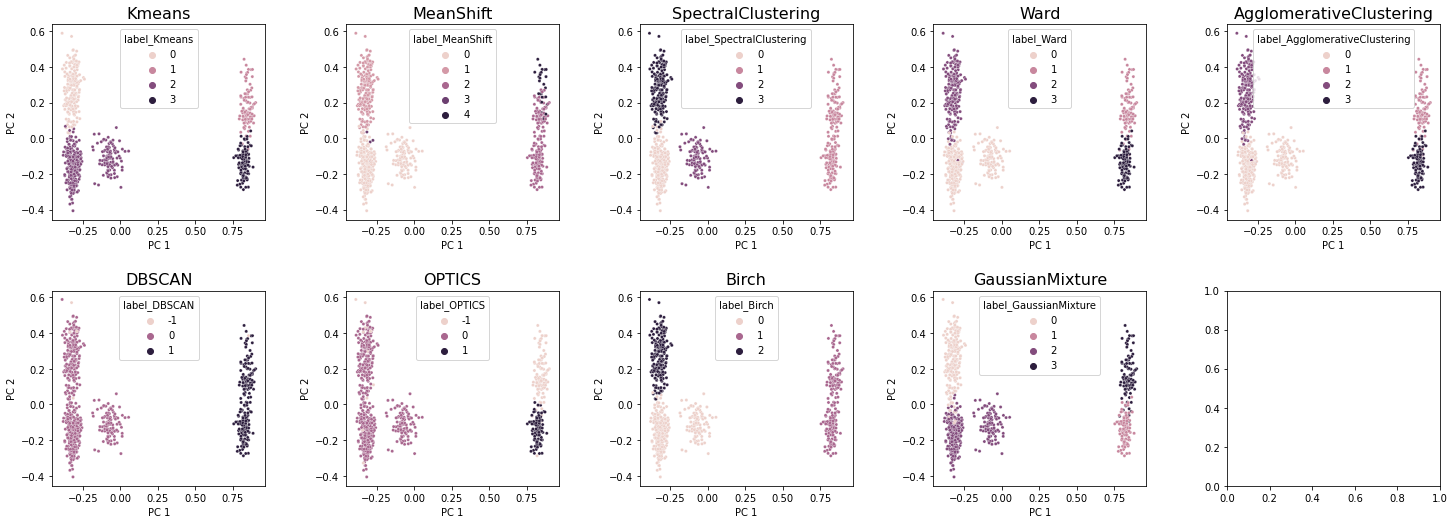

In [86]:
fig, axes = plt.subplots(int(len(datasets)*2), int(len(clustering_algorithms)/2+1), figsize=(20, 7))
plt.tight_layout(h_pad=5, w_pad=5)
for ax, col in zip(axes.flatten(), labels.columns):
    print(ax, col)
    sns.scatterplot(data=results, ax=ax,
                    x=results['PC 1'], y=results['PC 2'], s=10, hue=col)

    ax.set_title(col.split('_')[1], size=16)

In [82]:
score

,silhouette_Kmeans,silhouette_MeanShift,silhouette_SpectralClustering,silhouette_Ward,silhouette_AgglomerativeClustering,silhouette_DBSCAN,silhouette_OPTICS,silhouette_Birch,silhouette_GaussianMixture


In [62]:
def grid_csv(X, name, params):

    GSCV = GridSearchCV(algorithm, param_grid = paramCV, scoring = metrics.silhouette_score(X, labels['label_' + name], metric='euclidean'), cv = 5, n_jobs=-1, verbose=True)
    best_clf = GSCV.fit(X)
    best_hyperparams = best_clf.best_params_
    return name, best_hyperparams

In [63]:
from sklearn.model_selection import GridSearchCV
best_model_stack = list()

#paramCV = {'quantile': np.arange(0.1, 0.3, 0.02) #for bandwidth of RBF kernel in meanshift
#                 'eps': .3, #max distance between 2 samples for DBSCAN
#                 'damping': .1, #for Affinity Propagation:the extent to which the current value is maintained relative to incoming values
#                 'preference': -200, #for Affinity Propagation: each point - points with larger values of preferences are more likely to be chosen as exemplars.
#                 'n_neighbors': 2, #for k-neighbors graph for the connectivity matrix
#                 'n_clusters': 4, #for kmeans, ward, spectral, meanshift
#                 #for kmeans determine on elbow cf model_kmeans_simulated.ipynb
#                 'min_samples': 3, #fot OPTICS The number of samples in a neighborhood for a point to be considered as a core point
#                 'xi': 0.05, #for OPTICS Determines the minimum steepness on the reachability plot that constitutes a cluster boundary.
#                 'min_cluster_size': 0.1, # for optics Minimum number of samples in an OPTICS cluster, expressed as an absolute number or a fraction of the number of samples
#                 'random_state': random_state
#                }
#          ('Kmeans', two_means),
#         #('AffinityPropagation', affinity_propagation), EXCLUDED becuase of high complexity, most appropriate for small to medium sized datasets
#         ('MeanShift', ms),
#         ('SpectralClustering', spectral),
#         ('Ward', ward),
#         ('AgglomerativeClustering', average_linkage),
#         ('DBSCAN', dbscan),
#         ('OPTICS', optics),
#         ('Birch', birch),
#         ('GaussianMixture', gmm)
for name, algorithm in clustering_algorithms:
    if name == 'Kmeans':
        paramCV = {'n_clusters': [2 ,3 ,4, 5, 6]}
        best_model_stack.append(grid_csv(X, name, params))



ValueError: scoring should either be a single string or callable for single metric evaluation or a list/tuple of strings or a dict of scorer name mapped to the callable for multiple metric evaluation. Got 0.35457718284766193 of type <class 'numpy.float64'>